# Deep Learning Assignment 1

In [1]:
# importing necessary packages
import tensorflow

In [2]:
import keras

/Applications/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [67]:
import PIL
import h5py
from keras.utils import np_utils

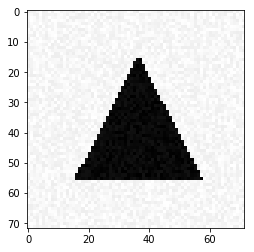

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

# 3 Simple Classification

In [183]:
# Generating dataset 
[X_train, Y_train] = generate_dataset_classification(300,20)

#X_train values are already normalized so don't have to normalize

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [184]:
#changing the target variable to categorical

target = to_categorical(Y_train)
n_cols = X_train.shape[1]

#creating the stochastic gradient descent model

sgd_model = Sequential()
sgd_model.add(Dense(100, activation = 'relu', input_shape = (n_cols,)))
sgd_model.add(Dense(3, activation = 'softmax'))
sgd_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
sgd_model.fit(X_train,target)

Epoch 1/10
300/300 [==============================] - 2s - loss: 2.2303 - acc: 0.4200     
Epoch 2/10
300/300 [==============================] - 0s - loss: 0.9887 - acc: 0.5800     
Epoch 3/10
300/300 [==============================] - 0s - loss: 0.9403 - acc: 0.5800     
Epoch 4/10
300/300 [==============================] - 0s - loss: 0.8971 - acc: 0.6133     
Epoch 5/10
300/300 [==============================] - 0s - loss: 0.7791 - acc: 0.6900     
Epoch 6/10
300/300 [==============================] - 0s - loss: 0.6907 - acc: 0.7200     
Epoch 7/10
300/300 [==============================] - 0s - loss: 0.7162 - acc: 0.6833     
Epoch 8/10
300/300 [==============================] - 0s - loss: 0.8277 - acc: 0.6467     
Epoch 9/10
300/300 [==============================] - 0s - loss: 0.5718 - acc: 0.7800     
Epoch 10/10
300/300 [==============================] - 0s - loss: 0.5169 - acc: 0.8000     


In [8]:
#Testing
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
print(X_test)
sgd_model.predict(X_test)

[[255. 255. 255. ... 255. 255. 255.]]


array([[0., 1., 0.]], dtype=float32)

In [157]:
#Creating Adam optimizer model
adams_model = Sequential()
adams_model.add(Dense(50, activation = 'relu', input_shape = (n_cols,)))
adams_model.add(Dense(3, activation = 'softmax'))
adams_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(patience = 2)
adams_model.fit(X_train,target, epochs=50, batch_size=32, validation_split = 0.3, callbacks = [es])

Train on 210 samples, validate on 90 samples
Epoch 1/50
210/210 [==============================] - 1s - loss: 1.6574 - acc: 0.3905 - val_loss: 0.7910 - val_acc: 0.5889
Epoch 2/50
210/210 [==============================] - 0s - loss: 0.8152 - acc: 0.5381 - val_loss: 0.6411 - val_acc: 0.7556
Epoch 3/50
210/210 [==============================] - 0s - loss: 0.6555 - acc: 0.6857 - val_loss: 0.5532 - val_acc: 0.7222
Epoch 4/50
210/210 [==============================] - 0s - loss: 0.5765 - acc: 0.6905 - val_loss: 0.4942 - val_acc: 0.7556
Epoch 5/50
210/210 [==============================] - 0s - loss: 0.5015 - acc: 0.8190 - val_loss: 0.4176 - val_acc: 0.7222
Epoch 6/50
210/210 [==============================] - 0s - loss: 0.4644 - acc: 0.7762 - val_loss: 0.3997 - val_acc: 0.8778
Epoch 7/50
210/210 [==============================] - 0s - loss: 0.4257 - acc: 0.9143 - val_loss: 0.3738 - val_acc: 0.8444
Epoch 8/50
210/210 [==============================] - ETA: 0s - loss: 0.4066 - acc: 0.875 - 0s

In [158]:
#Testing the adams_model
X_test = generate_a_rectangle()
X_test = X_test.reshape(1, X_test.shape[0])
adams_model.predict(X_test)

array([[1., 0., 0.]], dtype=float32)

#  4. Visualization problem

In [159]:
import matplotlib.cm as cm

#Visualization of the solution with the adam optimizer
visual = adams_model.get_weights()[0]
array1 = visual[:,0]
array2 = visual[:,1]
array3 = visual[:,2]

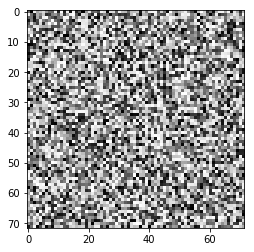

In [160]:
plt.imshow(array1.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap = cm.Greys)
plt.show()

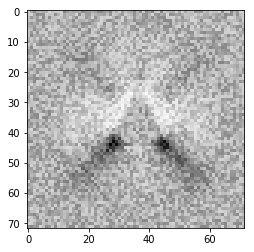

In [161]:
plt.imshow(array2.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap = cm.Greys)
plt.show()

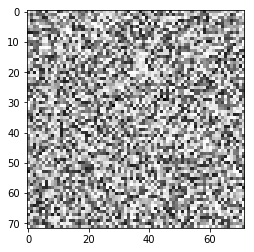

In [162]:
plt.imshow(array3.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap = cm.Greys)
plt.show()

# 5 More Classification

In [163]:
#Problem 5 with previous model

[X_train5, Y_train5] = generate_dataset_classification(300, 20, True)
target5 = to_categorical(Y_train5)
sgd_model.fit(X_train5,target5)

[X_test5, Y_test5] = generate_test_set_classification()
#Y_test is already encoded with to_categorical so there's no need to convert it

sgd_model.evaluate(X_test5, Y_test5)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Epoch 1/10
300/300 [==============================] - 0s - loss: 0.8204 - acc: 0.5667     
Epoch 2/10
300/300 [==============================] - 0s - loss: 0.8696 - acc: 0.5400     
Epoch 3/10
300/300 [==============================] - 0s - loss: 0.8195 - acc: 0.5467     
Epoch 4/10
300/300 [==============================] - 0s - loss: 0.8131 - acc: 0.5633     
Epoch 5/10
300/300 [==============================] - 0s - loss: 0.7917 - acc: 0.6000     
Epoch 6/10
300/300 [==============================] - 0s - loss: 0.8216 - acc: 0.5533     
Epoch 7/10
300/300 [==============================] - 0s - loss: 0.8063 - acc: 0.5900     
Epoch 8/10
300/300 [==============================] - 0s - loss: 0.8003 - acc: 0.5733     
Epoch 9/10
300/300 [==============================] - 0s - loss: 0.7980 - acc: 0.5833     
Epoch 10/10
300/300 [==============================] - 0s

[0.8948975626627604, 0.5266666658719381]

# Using Convolutional networks

In [77]:
#changing dimensions of the data to use it with convolutional networks

X_train_5 = X_train5.reshape(-1, IMAGE_SIZE,IMAGE_SIZE, 1)
print(X_train_5.shape)

X_test_5 = X_test5.reshape(-1, IMAGE_SIZE,IMAGE_SIZE, 1)
print(X_test_5.shape)


(300, 72, 72, 1)
(300, 72, 72, 1)


In [109]:
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.callbacks import EarlyStopping

In [118]:
#Problem 5 : New model

model5 = Sequential()
model5.add(Conv2D(16, kernel_size=(5, 5),activation='relu',input_shape=(72,72,1)))
model5.add(MaxPooling2D(pool_size=(2,2),padding='same'))
model5.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model5.add(MaxPooling2D(pool_size=(2,2),padding='same'))
model5.add(Flatten())                
model5.add(Dense(3, activation='softmax'))  
           
model5.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy']) 
model5.summary
early_stopping = EarlyStopping(patience = 4)
model5.fit(X_train_5, target5, epochs=50, batch_size=32, validation_split = 0.3, callbacks = [early_stopping])          
           

Train on 210 samples, validate on 90 samples
Epoch 1/50
210/210 [==============================] - 2s - loss: 1.2125 - acc: 0.4000 - val_loss: 1.1816 - val_acc: 0.3556
Epoch 2/50
210/210 [==============================] - 1s - loss: 1.0479 - acc: 0.4381 - val_loss: 0.9785 - val_acc: 0.4444
Epoch 3/50
210/210 [==============================] - 1s - loss: 0.9853 - acc: 0.4619 - val_loss: 0.9646 - val_acc: 0.6556
Epoch 4/50
210/210 [==============================] - 1s - loss: 0.8471 - acc: 0.7667 - val_loss: 0.8507 - val_acc: 0.6889
Epoch 5/50
210/210 [==============================] - 1s - loss: 0.7361 - acc: 0.6857 - val_loss: 0.7899 - val_acc: 0.7222
Epoch 6/50
210/210 [==============================] - 1s - loss: 0.6368 - acc: 0.8095 - val_loss: 0.7456 - val_acc: 0.7333
Epoch 7/50
210/210 [==============================] - 1s - loss: 0.5643 - acc: 0.7857 - val_loss: 0.8064 - val_acc: 0.6444
Epoch 8/50
210/210 [==============================] - 1s - loss: 0.4900 - acc: 0.8286 - val_lo

In [119]:
#Testing model5 on test set
model5.summary()
score = model5.evaluate(X_test_5, Y_test5, verbose=0)
print('Test loss:', score[0])
print('Test Accuracy:', score[1])

#Value of the loss function is 0.71

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 68, 68, 16)        416       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 34, 34, 16)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 32, 32, 64)        9280      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 16384)             0         
_________________________________________________________________
dense_72 (Dense)             (None, 3)                 49155     
Total params: 58,851
Trainable params: 58,851
Non-trainable params: 0
_________________________________________________________________
Test l

# 6 Regression Problem

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


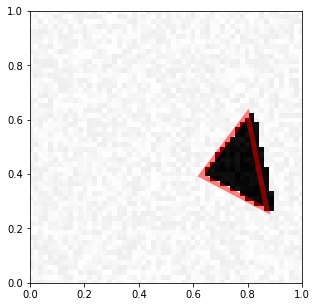

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
(300, 6)
(300, 5184)


In [121]:
# Genearte dataset and visualize one point 

[X_train_reg, Y_train_reg] = generate_dataset_regression(300, 20)
visualize_prediction(X_train_reg[10], Y_train_reg[10])

[X_test_reg, Y_test_reg] = generate_test_set_regression()

print(Y_train_reg.shape)
print(X_train_reg.shape)

In [124]:
from numpy import *
from keras.utils import normalize

#Normalizing y 

Y_scaled = normalize(Y_train_reg, axis=1)
print(Y_scaled.shape[1])

#Reshaping input data to use convolution layers

X_train6 = X_train_reg.reshape(-1, IMAGE_SIZE,IMAGE_SIZE, 1)
X_train6.shape

X_test6 = X_test_reg.reshape(-1, IMAGE_SIZE,IMAGE_SIZE, 1)

Y_test6 = normalize(Y_test_reg, axis=1)


6


In [171]:
# Regression model 

reg_model = Sequential()
reg_model.add(Conv2D(16, kernel_size=(5, 5),activation='relu',input_shape=(72,72,1)))
reg_model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
reg_model.add(Conv2D(64, kernel_size=(3, 3),activation='relu'))
reg_model.add(MaxPooling2D(pool_size=(2,2),padding='same'))

reg_model.add(Flatten())
reg_model.add(Dense(100, activation='relu'))
reg_model.add(Dense(6))

reg_model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
print("Loss function: " + reg_model.loss)

reg_model.fit(X_train6,Y_scaled, epochs = 30, batch_size=32)


Loss function: mean_squared_error
Epoch 1/30
300/300 [==============================] - 3s - loss: 0.5021 - acc: 0.1667     
Epoch 2/30
300/300 [==============================] - 1s - loss: 0.0564 - acc: 0.1867     
Epoch 3/30
300/300 [==============================] - 1s - loss: 0.0398 - acc: 0.1933     
Epoch 4/30
300/300 [==============================] - 1s - loss: 0.0373 - acc: 0.2333     
Epoch 5/30
300/300 [==============================] - 1s - loss: 0.0352 - acc: 0.3033     
Epoch 6/30
300/300 [==============================] - 1s - loss: 0.0330 - acc: 0.3567     
Epoch 7/30
300/300 [==============================] - 1s - loss: 0.0302 - acc: 0.4067     
Epoch 8/30
300/300 [==============================] - 1s - loss: 0.0281 - acc: 0.4133     
Epoch 9/30
300/300 [==============================] - 1s - loss: 0.0253 - acc: 0.4533     
Epoch 10/30
300/300 [==============================] - 2s - loss: 0.0230 - acc: 0.4967     
Epoch 11/30
300/300 [==============================] - 

In [172]:
reg_model.evaluate(X_test6, Y_test6)

288/300 [===========================>..] - ETA: 0s

[0.05446882208188375, 0.2533333335320155]

# 7 Image Denoising

In [173]:
#Generate pair of images, one with noise and one without
def generate_a_drawing_2(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata_n = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata_n, imdata

def generate_a_rectangle_2(free_location=False):
    noise = np.random.randint(0,50) #add noise
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing_2(figsize, U, V, noise)


def generate_a_disk_2(free_location=False):
    noise = np.random.randint(0,50) 
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing_2(figsize, U, V, noise)

def generate_a_triangle_2(free_location=False):
    noise = np.random.randint(0,50) 
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing_2(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

def generate_dataset_classification_2(nb_samples, free_location=False):
    noise = np.random.randint(0,50) 
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,2,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle_2(free_location)
        elif category == 1: 
            X[i] = generate_a_disk_2(free_location)
        else:
            [X[i], V] = generate_a_triangle_2(free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

In [175]:
train, old = generate_dataset_classification_2(300)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [180]:
#Make training data
X_train7 = train[:,0]
Y_train7 = train[:,1]

X_train7 = X_train7.reshape(-1, 72,72,1)

In [182]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(5, 5),activation='relu',input_shape=(72,72,1)))
model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
model.add(Flatten())
model.add(Dense(100, activation = 'relu'))
model.add(Dense(3))  